## AdaBoosting

### AdaBoosting의 멤버수, 학습률 테스트

In [1]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [3]:
# 데이터 생성

X1, y1 = make_gaussian_quantiles(cov=2, n_samples=100, n_features=2,
                                n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                n_samples=200, n_features=2,
                                n_classes=2, random_state=1)

X = np.concatenate((X1, X2))
y = np.concatenate((y1, y2))

In [5]:
X1.shape, X2.shape, y1.shape, y2.shape

((100, 2), (200, 2), (100,), (200,))

In [6]:
X1[:5]

array([[-0.2638495 , -0.14389039],
       [ 1.80136291,  2.78190197],
       [-1.79966985,  0.44342344],
       [ 1.18650172,  1.31677719],
       [ 2.34731475,  1.04940892]])

In [7]:
X2[:5]

array([[ 3.60650753,  2.7860332 ],
       [-0.42081653,  5.37297848],
       [ 3.13009574,  1.13143086],
       [ 1.55196194,  2.18462057],
       [ 5.21744335,  1.40081765]])

In [8]:
y1[:5]

array([0, 1, 1, 1, 1])

In [9]:
y2[:5]

array([0, 1, 1, 1, 1])

#### 개별 모형 증가에 따른 성능 테스트

In [10]:
from sklearn.model_selection import cross_val_score

In [33]:
%%time

accs = []

for n in range(1, 1001, 100) : 
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=n)
    accs.append(cross_val_score(ada, X, y, cv=5).mean())

Wall time: 21.6 s


In [13]:
%matplotlib inline

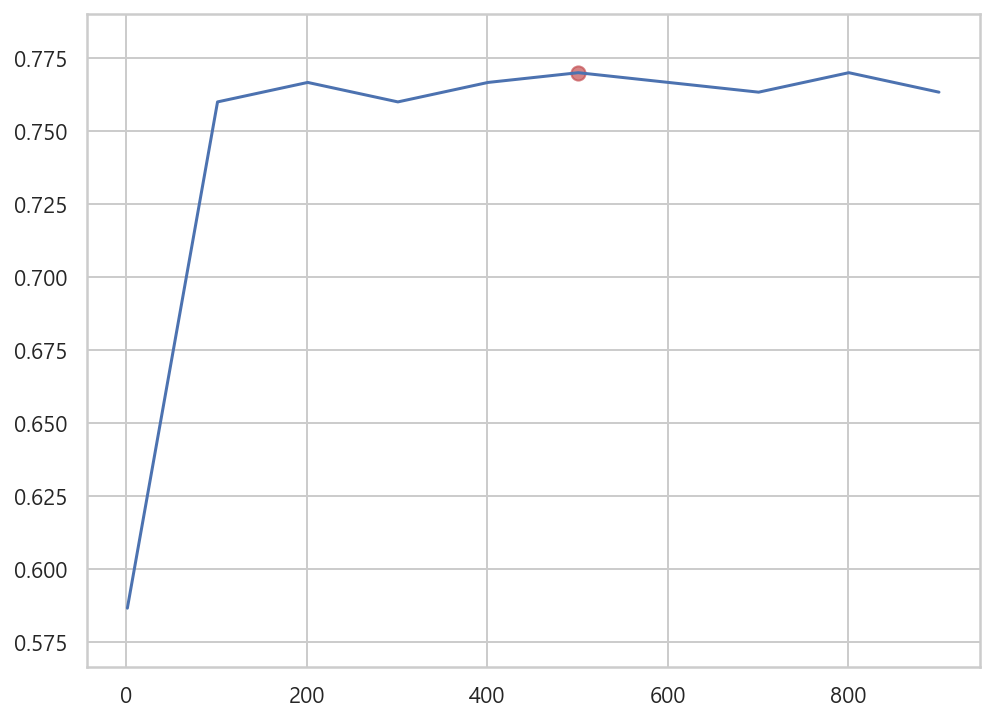

In [43]:
max_acc = np.max(accs)
max_idx = np.argmax(np.array(accs))

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 1001, 100), accs)
plt.scatter(np.arange(1, 1001, 100)[max_idx], max_acc, s=50, c="r", alpha=0.7)
plt.ylim(np.min(accs)-0.02, np.max(accs)+0.02)
plt.show() ; 

In [51]:
mean_test_acc = []
learning_space = np.linspace(0, 1, 10).round(2)

for l in learning_space : 
    base_model = DecisionTreeClassifier(max_depth=2, criterion="entropy")
    ada_boost = AdaBoostClassifier(base_model, learning_rate=l, n_estimators=1000)
    mean_test_acc.append(cross_val_score(ada_boost, X, y, cv=5,
                                         scoring="accuracy").mean())

In [67]:
learning_space

array([0.  , 0.11, 0.22, 0.33, 0.44, 0.56, 0.67, 0.78, 0.89, 1.  ])

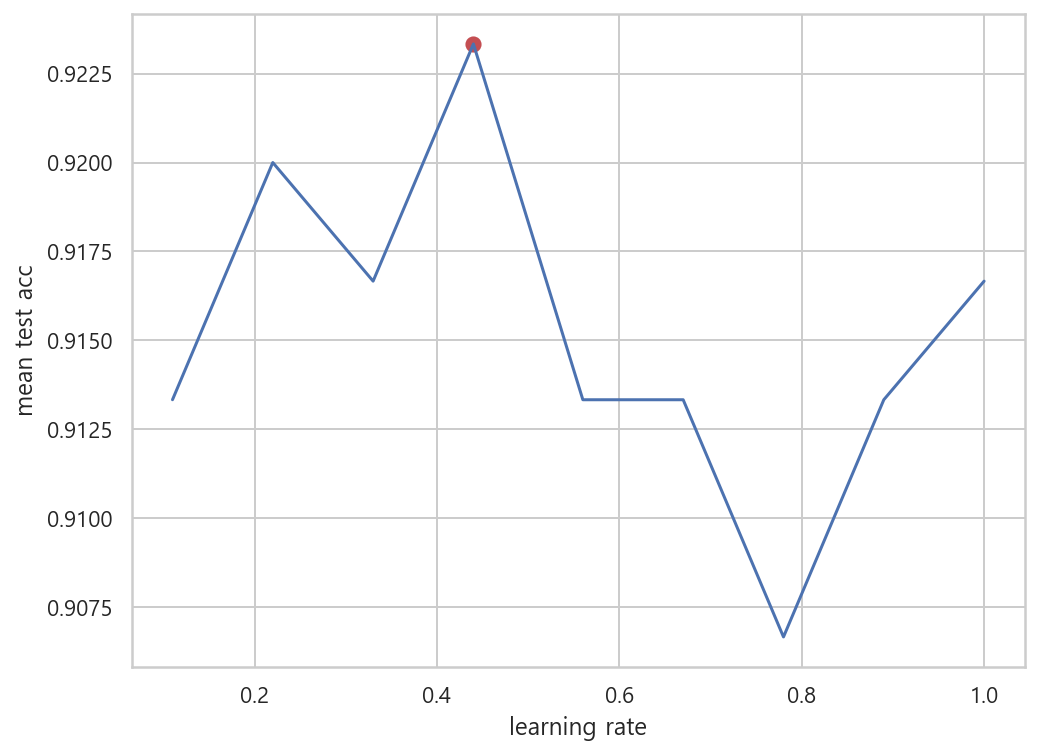

In [63]:
max_score = np.max(mean_test_acc[1:])
max_idx = np.argmax(mean_test_acc[1:]) + 1

plt.figure(figsize=(8, 6))
plt.plot(learning_space, mean_test_acc)
plt.scatter(learning_space[max_idx], max_score, s=50, c="r")
plt.xlabel("learning rate")
plt.ylabel("mean test acc")
plt.show() ; 

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [70]:
%%time

base_model = DecisionTreeClassifier(max_depth=2, criterion="entropy", random_state=0)
pipe = Pipeline([('boost', AdaBoostClassifier())])
params = {"boost__n_estimators": [n for n in range(1, 1001, 100)],
         "boost__learning_rate": [n for n in np.linspace(0, 1, 15).round(2)][1:]}

grid_ada = GridSearchCV(estimator=pipe, param_grid=params, cv=5, 
                        scoring="accuracy", verbose=1)
grid_ada.fit(X, y)

Fitting 5 folds for each of 140 candidates, totalling 700 fits
Wall time: 5min 10s


GridSearchCV(cv=5, estimator=Pipeline(steps=[('boost', AdaBoostClassifier())]),
             param_grid={'boost__learning_rate': [0.07, 0.14, 0.21, 0.29, 0.36,
                                                  0.43, 0.5, 0.57, 0.64, 0.71,
                                                  0.79, 0.86, 0.93, 1.0],
                         'boost__n_estimators': [1, 101, 201, 301, 401, 501,
                                                 601, 701, 801, 901]},
             scoring='accuracy', verbose=1)

In [71]:
grid_ada.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_boost__learning_rate', 'param_boost__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [74]:
cols = ["mean_test_score", "std_test_score", 
        "param_boost__n_estimators", "param_boost__learning_rate", "rank_test_score"]
result_df = pd.DataFrame(grid_ada.cv_results_)[cols].sort_values("rank_test_score", ascending=True).reset_index(drop=True)
result_df[:10]

,mean_test_score,std_test_score,param_boost__n_estimators,param_boost__learning_rate,rank_test_score
0,0.803333,0.092736,601,0.14,1
1,0.800000,0.091287,901,0.14,2
2,0.800000,0.091287,801,0.14,2
3,0.800000,0.091287,701,0.14,2
4,0.796667,0.089691,201,0.43,5
5,0.796667,0.087813,401,0.29,5
6,0.793333,0.093452,301,0.29,7
7,0.793333,0.091043,801,0.07,7
8,0.793333,0.090431,501,0.21,7
9,0.790000,0.092256,401,0.21,10


In [76]:
result_df_1 = result_df[:10]
result_df_1

,mean_test_score,std_test_score,param_boost__n_estimators,param_boost__learning_rate,rank_test_score
0,0.803333,0.092736,601,0.14,1
1,0.800000,0.091287,901,0.14,2
2,0.800000,0.091287,801,0.14,2
3,0.800000,0.091287,701,0.14,2
4,0.796667,0.089691,201,0.43,5
5,0.796667,0.087813,401,0.29,5
6,0.793333,0.093452,301,0.29,7
7,0.793333,0.091043,801,0.07,7
8,0.793333,0.090431,501,0.21,7
9,0.790000,0.092256,401,0.21,10


In [81]:
%%time

base_model = DecisionTreeClassifier(max_depth=2, criterion="entropy", random_state=0)
pipe = Pipeline([('boost', AdaBoostClassifier())])
params = {"boost__n_estimators": [n for n in range(0, 1001, 100)],
         "boost__learning_rate": [n for n in np.linspace(0, 1, 10).round(1)][1:]}

grid_ada_2 = GridSearchCV(estimator=pipe, param_grid=params, cv=5, 
                        scoring="accuracy", verbose=1)
grid_ada_2.fit(X, y)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
Wall time: 4min 1s


GridSearchCV(cv=5, estimator=Pipeline(steps=[('boost', AdaBoostClassifier())]),
             param_grid={'boost__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.6, 0.7,
                                                  0.8, 0.9, 1.0],
                         'boost__n_estimators': [0, 100, 200, 300, 400, 500,
                                                 600, 700, 800, 900, 1000]},
             scoring='accuracy', verbose=1)

In [82]:
cols = ["mean_test_score", "std_test_score", 
        "param_boost__n_estimators", "param_boost__learning_rate", "rank_test_score"]
result_df = pd.DataFrame(grid_ada_2.cv_results_)[cols].sort_values("rank_test_score", ascending=True).reset_index(drop=True)
result_df[:10]

,mean_test_score,std_test_score,param_boost__n_estimators,param_boost__learning_rate,rank_test_score
0,0.800000,0.091287,300,0.3,1
1,0.796667,0.092135,400,0.3,2
2,0.796667,0.092135,900,0.1,2
3,0.796667,0.092135,1000,0.1,2
4,0.793333,0.090431,500,0.2,5
5,0.790000,0.094634,500,0.1,6
6,0.790000,0.091652,700,0.2,6
7,0.790000,0.091652,600,0.2,6
8,0.786667,0.093333,300,0.4,9
9,0.786667,0.096264,1000,0.2,10


In [89]:
result_df_2 = result_df[:10]
df = pd.concat([result_df_1, result_df_2]).sort_values("mean_test_score", ascending=False).reset_index(drop=True)
df

,mean_test_score,std_test_score,param_boost__n_estimators,param_boost__learning_rate,rank_test_score
0,0.803333,0.092736,601,0.14,1
1,0.800000,0.091287,701,0.14,2
2,0.800000,0.091287,901,0.14,2
3,0.800000,0.091287,300,0.3,1
4,0.800000,0.091287,801,0.14,2
5,0.796667,0.089691,201,0.43,5
6,0.796667,0.087813,401,0.29,5
7,0.796667,0.092135,400,0.3,2
8,0.796667,0.092135,900,0.1,2
9,0.796667,0.092135,1000,0.1,2


## sklearn docs Adaboost

### multi-class adaboosted decision tree test

In [2]:
from sklearn.datasets import make_gaussian_quantiles

In [3]:
# 2000개 샘플, 10개의 독립변수, 3가지 클래스

X, y = make_gaussian_quantiles(
    n_samples=2000, n_features=10, n_classes=3, random_state=1)

X.shape, y.shape

((2000, 10), (2000,))

In [4]:
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([666, 666, 668], dtype=int64))

In [6]:
y[:10]

array([0, 1, 1, 1, 0, 2, 0, 2, 1, 1])

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
                                X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1400, 10), (600, 10), (1400,), (600,))

In [9]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [15]:
weak_clf = DecisionTreeClassifier(max_leaf_nodes=8)
n_estimators = 300
adaboost_clf = AdaBoostClassifier(base_estimator=weak_clf, 
                                  n_estimators=n_estimators,
                                  algorithm="SAMME",
                                  random_state=42).fit(X_train, y_train)

#### 부스팅의 성능 검증
- 두 가지 기준점수 비교
   - weak_clf 분류 에러 : 1 - acc(y_test, weak_clf.predict(X_test))
   - dummyclassifier 분류 에러 : 1 - acc(y_test, dummy.predict(X_test))
- dummyclassifier 는 데이터에서 가장 널리 퍼진 클래스를 예측한다?   

In [17]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

In [18]:
def get_misclf_error(y_true, y_pred) :
    
    return 1 - accuracy_score(y_true, y_pred)

In [19]:
weak_clf.fit(X_train, y_train)
weak_error = get_misclf_error(y_test, weak_clf.predict(X_test))

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
dummy_error = get_misclf_error(y_test, dummy_clf.predict(X_test))

print("weak error : {:.3f}".format(weak_error))
print("dummy error : {:.3f}".format(dummy_error))

weak error : 0.475
dummy error : 0.692


In [26]:
boosting_errors = pd.DataFrame({
    "number of trees": range(1, n_estimators + 1),
    "ada boost": [
        get_misclf_error(y_test, y_pred) \
        for y_pred in adaboost_clf.staged_predict(X_test)
    ]
}).set_index("number of trees")

boosting_errors

,ada boost
number of trees,
1,0.475000
2,0.618333
3,0.483333
4,0.393333
5,0.496667
...,...
296,0.300000
297,0.296667
298,0.301667


In [39]:
boosting_errors["ada boost"].describe()

count    300.000000
mean       0.314817
std        0.034464
min        0.273333
25%        0.300000
50%        0.306667
75%        0.313333
max        0.618333
Name: ada boost, dtype: float64

In [27]:
%matplotlib inline

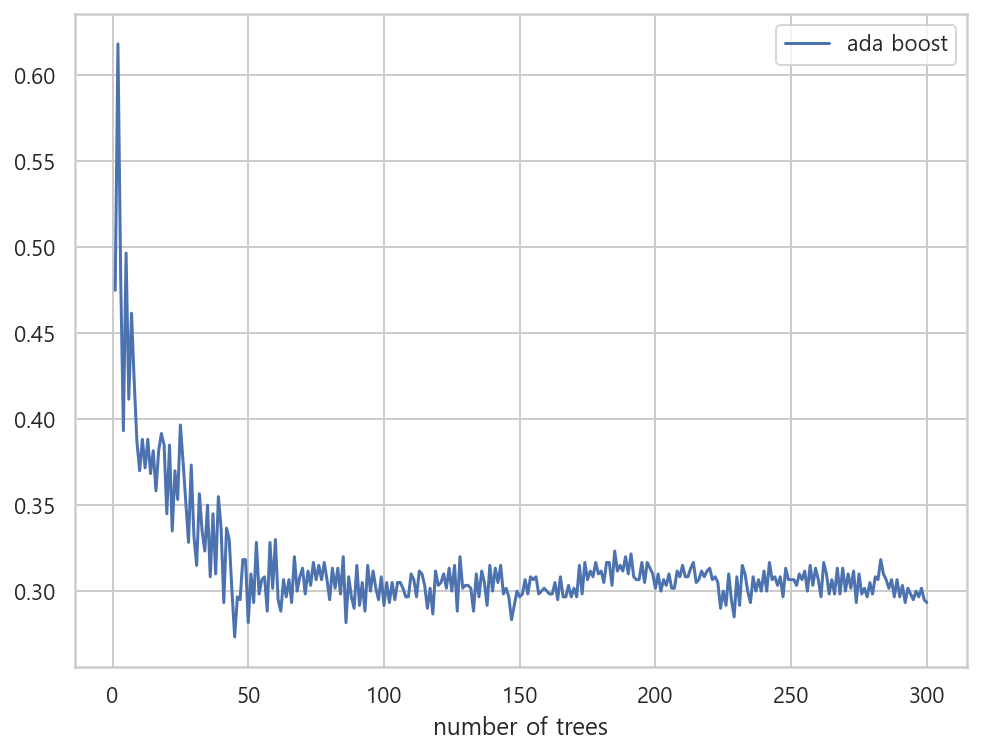

In [30]:
ax = boosting_errors.plot(figsize=(8, 6))
plt.show() ; 

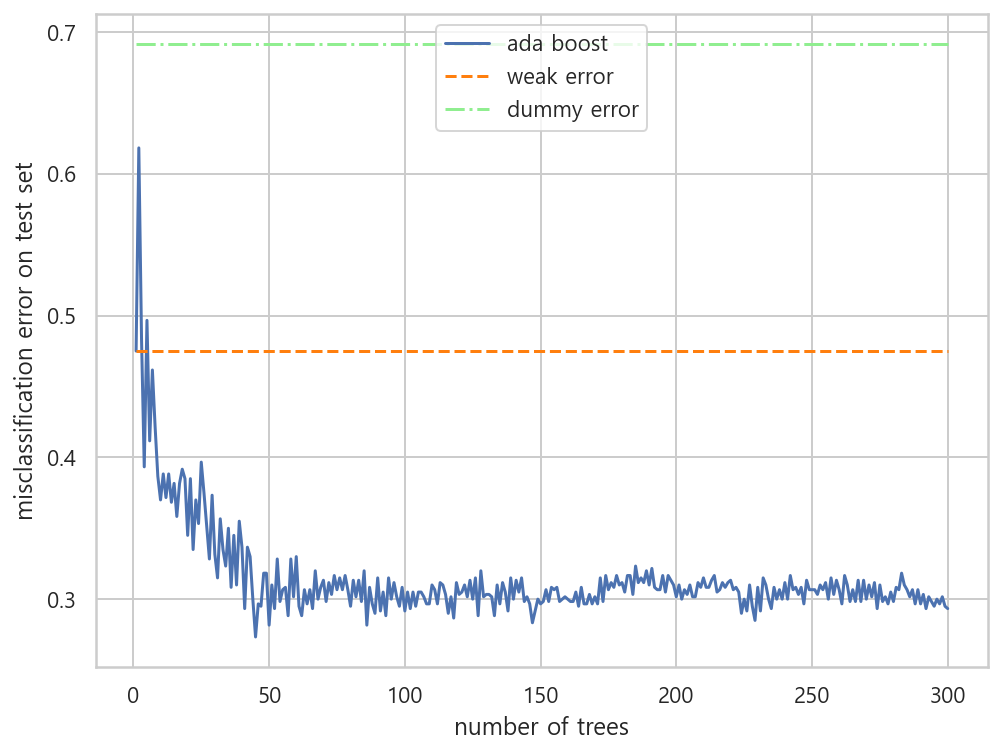

In [38]:
ax = boosting_errors.plot(figsize=(8, 6), label="ada boost")
# weak_error
plt.plot([boosting_errors.index.min(), boosting_errors.index.max()],
         [weak_error, weak_error], color="tab:orange", 
         linestyle="--", label="weak error")
# dummy_error
plt.plot([boosting_errors.index.min(), boosting_errors.index.max()],
         [dummy_error, dummy_error], color="lightgreen", 
         linestyle="-.", label="dummy error")

plt.xlabel("number of trees")
plt.ylabel("misclassification error on test set")
plt.legend()
plt.show() ; 

In [33]:
boosting_errors.index.min(), weak_error

(1, 0.475)

In [34]:
boosting_errors.index.max(), weak_error

(300, 0.475)

#### adaboost의 estimator_errors_, estimator_weights_테스트

In [40]:
weak_info = pd.DataFrame({
    "number of trees": range(1, n_estimators + 1),
    "errors": adaboost_clf.estimator_errors_,
    "weight": adaboost_clf.estimator_weights_
}).set_index("number of trees")

weak_info

,errors,weight
number of trees,,
1,0.460000,0.853490
2,0.458535,0.859391
3,0.440276,0.933190
4,0.466907,0.825714
5,0.480702,0.770379
...,...,...
296,0.505371,0.671664
297,0.487767,0.742088
298,0.507746,0.662161


In [42]:
adaboost_clf.estimator_errors_[:10]

array([0.46      , 0.45853462, 0.44027581, 0.46690673, 0.4807016 ,
       0.4594246 , 0.48251563, 0.47778756, 0.4828311 , 0.49040268])

In [44]:
adaboost_clf.estimator_weights_[:10]

array([0.85348983, 0.85939051, 0.93318995, 0.82571405, 0.77037916,
       0.85580646, 0.76311321, 0.78205544, 0.76184979, 0.73154116])

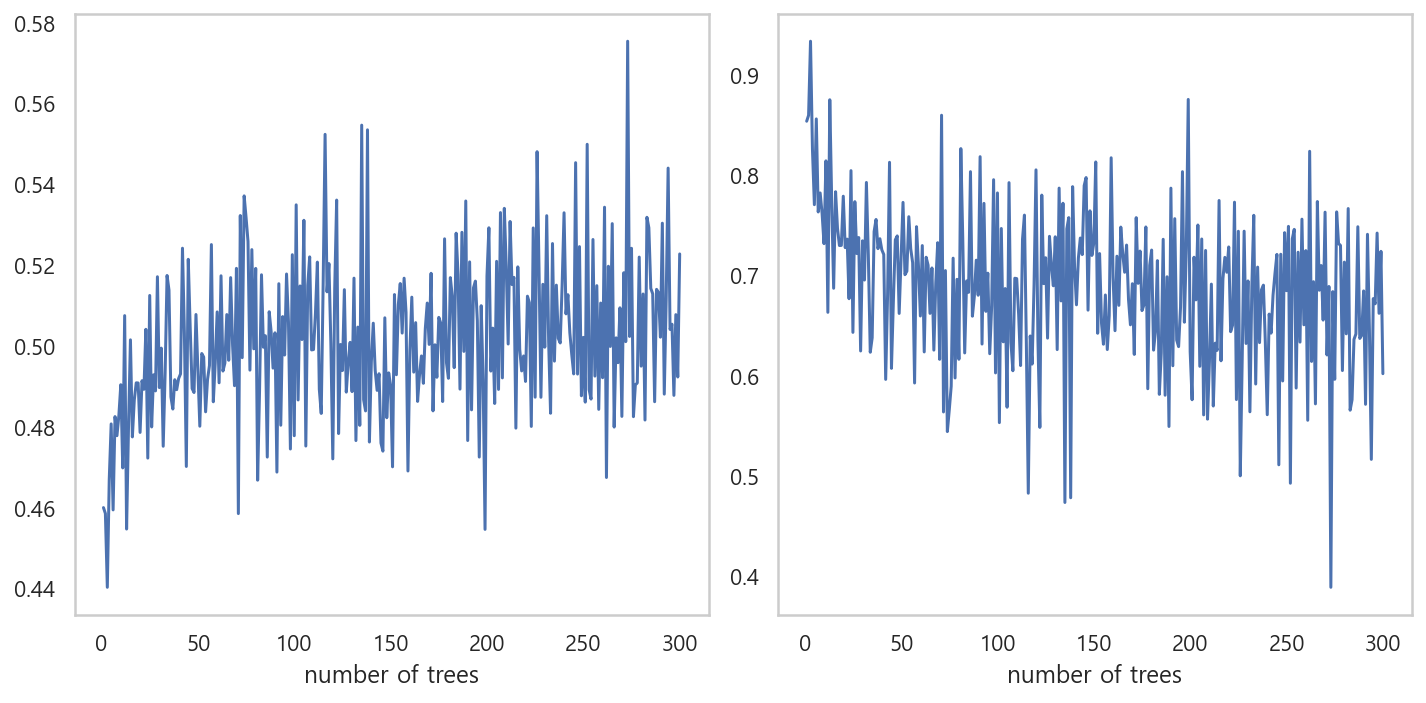

In [52]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
weak_info["errors"].plot()
plt.grid(False)

plt.subplot(122)
weak_info["weight"].plot()
plt.grid(False)

plt.tight_layout()
plt.show() ; 

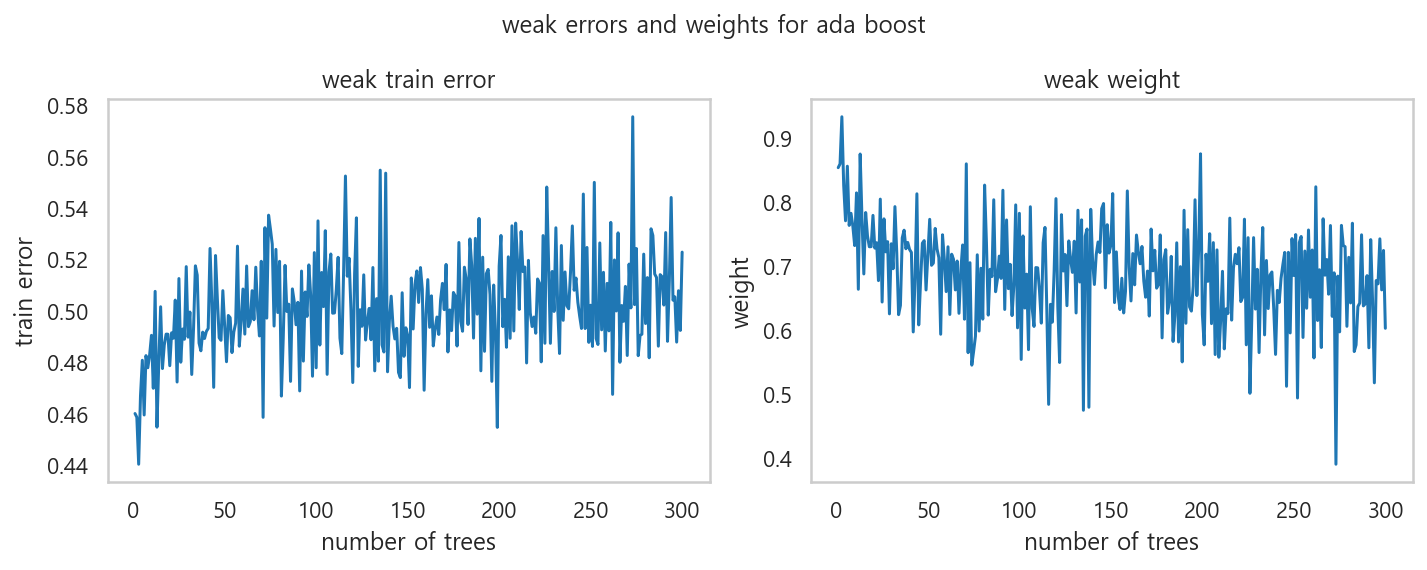

In [56]:
axs = weak_info.plot(subplots=True, layout=(1, 2), figsize=(10, 4), 
                     legend=False, color="tab:blue", grid=False)
axs[0, 0].set_ylabel("train error")
axs[0, 0].set_title("weak train error")
axs[0, 1].set_ylabel("weight")
axs[0, 1].set_title("weak weight")
fig = axs[0, 0].get_figure()
fig.suptitle("weak errors and weights for ada boost")
fig.tight_layout()
plt.show() ; 

In [57]:
import seaborn as sns

In [62]:
colors_1 = sns.color_palette("colorblind")
colors_1

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [63]:
colors_1[0]

(0.00392156862745098, 0.45098039215686275, 0.6980392156862745)

In [65]:
colors_1[1]

(0.8705882352941177, 0.5607843137254902, 0.0196078431372549)

In [66]:
colors_2 = sns.color_palette("pastel")
colors_2

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [67]:
colors_3 = sns.color_palette("deep")
colors_3

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

## Gradient decent tree
- GradientBoostingClassifier
- HistGradientBoostingClassifier

In [1]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import HistGradientBoostingClassifier

In [2]:
X, y = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

X.shape, y.shape

((12000, 10), (12000,))

In [3]:
X_train.shape, X_test.shape

((2000, 10), (10000, 10))

In [4]:
y_train.shape, y_test.shape

((2000,), (10000,))

In [9]:
set(y)

{-1.0, 1.0}

In [6]:
hist_clf = HistGradientBoostingClassifier(max_iter=100).fit(X_train, y_train)
hist_clf.score(X_test, y_test)

0.8965

#### Histgbc 결측값 테스트

In [10]:
X = np.array([0, 1, 2, np.nan]).reshape(-1, 1)
X

array([[ 0.],
       [ 1.],
       [ 2.],
       [nan]])

In [11]:
X.shape

(4, 1)

In [12]:
y = [0, 0, 0, 1]
y

[0, 0, 0, 1]

In [13]:
histg = HistGradientBoostingClassifier(min_samples_leaf=1).fit(X, y)
histg.predict(X)

array([0, 0, 0, 1])

In [15]:
X = np.array([0, np.nan, 1, 2, np.nan, 3, 0]).reshape(-1, 1)
y = [0, 1, 0, 0, 1, 2, 0]

histg = HistGradientBoostingClassifier(min_samples_leaf=1, max_depth=2,
                                      learning_rate=1, max_iter=1).fit(X, y)
histg.predict(X)

array([0, 1, 0, 0, 1, 2, 0])

## Gradient Boosting regularization
- 그래디언트 부스팅 정규화 방법
- learning_rate < 1.0 을 적용하면 정규화 성능을 향상시켜준다.
- shirinkage와 stocastic gradient boosting을 사용하면 분산을 줄여 더 정확한 모델을 만들 수 있다. 
- 분산을 줄이는 다른 방법
   - randomforest 처럼 훈련 데이터의 무작위 분할 방법
   - max_features 매개변수 조정

In [25]:
from sklearn.datasets import make_hastie_10_2

In [26]:
X, y = make_hastie_10_2(n_samples=4000, random_state=1)

X.shape, y.shape

((4000, 10), (4000,))

In [28]:
labels, y = np.unique(y, return_inverse=True)
labels, y

(array([-1.,  1.]), array([1, 1, 0, ..., 0, 0, 0], dtype=int64))

In [31]:
set(y), set(labels)

({0, 1}, {-1.0, 1.0})

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8,
                                                    random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 10), (3200, 10), (800,), (3200,))

In [48]:
origin_params = {
    "n_estimators": 400,
    "max_leaf_nodes": 4, 
    "max_depth": None,
    "random_state": 2,
    "min_samples_split": 5
}

origin_params

{'n_estimators': 400,
 'max_leaf_nodes': 4,
 'max_depth': None,
 'random_state': 2,
 'min_samples_split': 5}

#### params 변경과 plot color 조합
- learning_rate, subsample parameter 조정

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss

In [58]:
%matplotlib inline

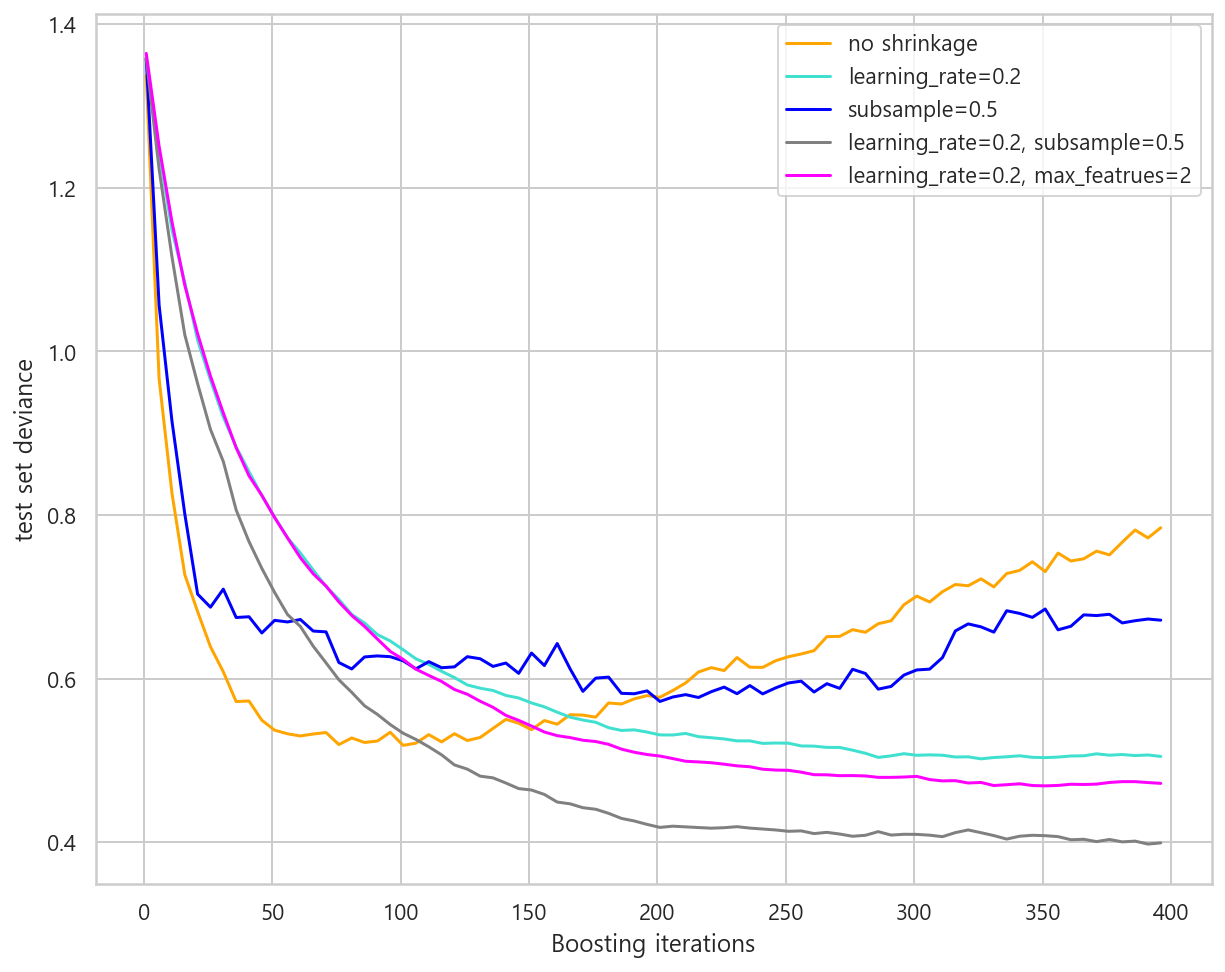

In [59]:
plt.figure(figsize=(10, 8))

for label, color, setting in [
    ("no shrinkage", "orange", {"learning_rate": 1.0, "subsample": 1.0}),
    ("learning_rate=0.2", "turquoise", {"learning_rate": 0.2, "subsample": 1.0}),
    ("subsample=0.5", "blue", {"learning_rate":1.0, "subsample": 0.5}),
    ("learning_rate=0.2, subsample=0.5", "gray", {"learning_rate": 0.2, "subsample": 0.5}),
    ("learning_rate=0.2, max_featrues=2", "magenta", {"learning_rate": 0.2, "max_features": 2})
] : 
    # dict에 key 값이 같으면 values 값을 변환함
    params = dict(origin_params)
    params.update(setting)
    
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    
    # n_estimators 갯수 만큼 zeros 생성
    test_deviance = np.zeros((params["n_estimators"],), dtype=np.float64)
    
    # 각 단계별로 확률값 반환 : staged_predict_proba()
    for i, y_proba in enumerate(clf.staged_predict_proba(X_test)) : 
        test_deviance[i] = 2 * log_loss(y_test, y_proba[:, 1])
        
    plt.plot(
        (np.arange(test_deviance.shape[0])+1)[::5],
        test_deviance[::5], "-", color=color, label=label
    )
    
plt.legend()
plt.xlabel("Boosting iterations")
plt.ylabel("test set deviance")
plt.show() ; 

## GB out-of-bag estimates
- out-of-bag : 훈련 데이터가 아닌 데이터를 사용하는 방법
- 부스팅 모델에서 최적 반복 횟추를 추정 방법
   - 교차 검증과 유사함
   - 반복적인 모델 피팅(모수추정)없이 즉시 계산 가능
   - stochastic gradient boosting 모델만 적용 가능
   - bootstap 에 포함되지 않은 샘플을 대상으로 평가함
- clf.oob_improvement_ 값을 누적 합하여 사용할 수 있다.   

In [179]:
n_samples = 1000
random_state = np.random.RandomState(13)
x1 = random_state.uniform(size=n_samples)
x2 = random_state.uniform(size=n_samples)
x3 = random_state.randint(0, 4, size=n_samples)

In [180]:
x1.shape, x2.shape, x3.shape

((1000,), (1000,), (1000,))

#### 로지스틱 시그모이드 함수

In [181]:
from scipy.special import expit

In [182]:
p = expit(np.sin(3 * x1) - 4 * x2 + x3)

p.shape

(1000,)

In [183]:
# 로지스틱 시그모이드 함수로 만든 분포를 사용

y = random_state.binomial(1, p, size=n_samples)

y.shape

(1000,)

In [184]:
set(y)

{0, 1}

In [185]:
X = np.c_[x1, x2, x3]
X = X.astype(np.float32)
X.shape

(1000, 3)

In [186]:
from sklearn.model_selection import train_test_split

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=9)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((500, 3), (500, 3), (500,), (500,))

### model fitting

In [188]:
params = {
    "n_estimators": 1200,
    "max_depth": 3,
    "subsample": 0.5, 
    "learning_rate": 0.01,
    "min_samples_leaf": 1,
    "random_state": 3
}

clf = GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print("Accuracy : {:.4f}".format(acc))

Accuracy : 0.6800


In [189]:
n_estimators = params["n_estimators"]
x = np.arange(n_estimators) + 1

x.shape

(1200,)

### log_loss 계산 함수
- 모델 집합이 추가 될 때마다 확률값 반환
   - 1200

In [83]:
from sklearn.metrics import log_loss

In [190]:
def heldout_score(clf, X_test, y_test) : 
    
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, y_proba in enumerate(clf.staged_predict_proba(X_test)) : 
        score[i] = 2 * log_loss(y_test, y_proba[:, 1])
        
    return score

### cv score 계산 함수
- log_loss 값을 교차 검증 횟수로 나눈 값
- 즉 교차 검증 당 score
- out-of-bag : 훈련에 사용하지 않은 샘플로 평가함

In [85]:
from sklearn.model_selection import KFold, cross_val_score

In [191]:
def cv_estimate(n_splits=None) : 
    
    cv = KFold(n_splits=n_splits)
    cv_clf = GradientBoostingClassifier(**params)
    val_scores = np.zeros((n_estimators, ), dtype=np.float64)
    
    # cv.split : 데이터를 train, test 집합으로 구분하고 인덱스 반환
    for train, test in cv.split(X_train, y_train) :
        cv_clf.fit(X_train[train], y_train[train])
        # out-of-bag 평가 : 사용되지 않은 샘플로 평가
        val_scores += heldout_score(cv_clf, X_train[test], y_train[test])
    val_scores /= n_splits
    
    return val_scores

### cross_val
- out-of-bag 으로 계산

In [192]:
cv_score = cv_estimate(3)
cv_score

array([1.38206107, 1.37672064, 1.37078415, ..., 1.25194457, 1.25229826,
       1.25236937])

In [193]:
cv_score.shape

(1200,)

### best n_estimator for test data

In [194]:
test_score = heldout_score(clf, X_test, y_test)
test_score.shape

(1200,)

### negative oob_improvements 값의 누적 합계

In [195]:
cumsum = -np.cumsum(clf.oob_improvement_)
cumsum.shape

(1200,)

In [196]:
test = np.array([1, 2, 3, 4])
test_cumsum = - np.cumsum(test)
test_cumsum

array([ -1,  -3,  -6, -10], dtype=int32)

### min loss oob

In [197]:
oob_best_iter = x[np.argmin(cumsum)]
oob_best_iter

160

In [198]:
np.argmin(cumsum)

159

### min loss test score normalize

In [199]:
test_score

array([1.38176281, 1.37597256, 1.3712185 , ..., 1.21166988, 1.21148576,
       1.21130124])

In [200]:
test_score -= test_score[0]
test_best_iter = x[np.argmin(test_score)]
test_best_iter

301

### min loss cv_score normalize

In [201]:
cv_score -= cv_score[0]
cv_best_iter = x[np.argmin(cv_score)]
cv_best_iter

253

### plot

In [155]:
oob_color = list(map(lambda x : x/256.0, (190, 174, 212)))
oob_color

[0.7421875, 0.6796875, 0.828125]

In [156]:
190/256

0.7421875

In [157]:
test_color = list(map(lambda x : x/256.0, (127, 201, 127)))
test_color

[0.49609375, 0.78515625, 0.49609375]

In [158]:
cv_color = list(map(lambda x : x/256.0, (253, 192, 134)))
cv_color

[0.98828125, 0.75, 0.5234375]

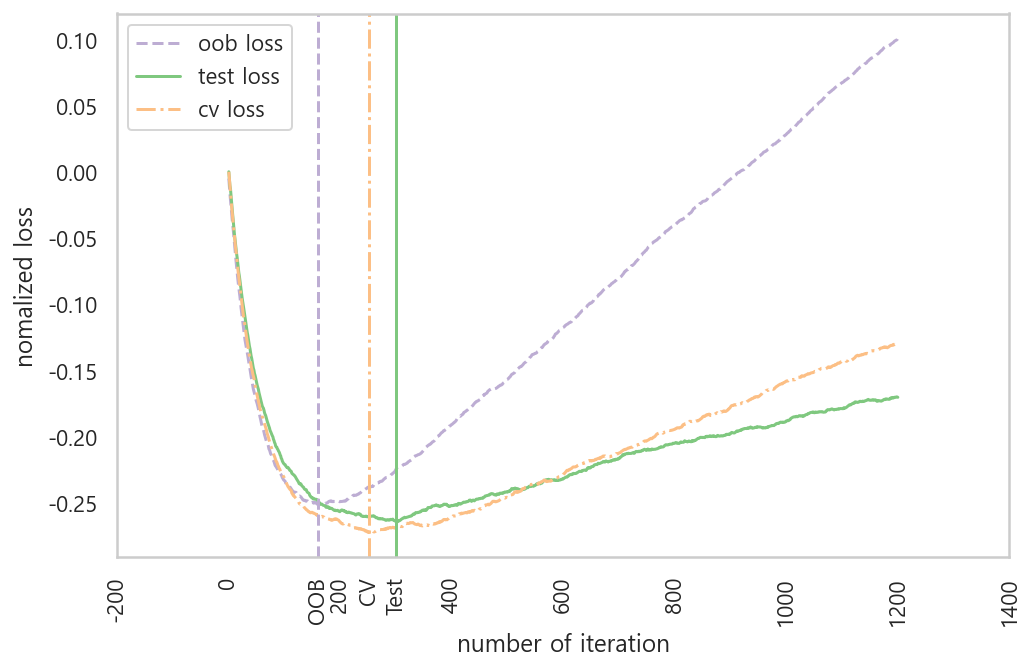

In [202]:
oob_line = "dashed"
test_line = "solid"
cv_line = "dashdot"

plt.figure(figsize=(8, 5))
plt.plot(x, cumsum, label="oob loss", color=oob_color, linestyle=oob_line)
plt.plot(x, test_score, label="test loss", color=test_color, linestyle=test_line)
plt.plot(x, cv_score, label="cv loss", color=cv_color, linestyle=cv_line)
plt.axvline(x=oob_best_iter, color=oob_color, linestyle=oob_line)
plt.axvline(x=test_best_iter, color=test_color, linestyle=test_line)
plt.axvline(x=cv_best_iter, color=cv_color, linestyle=cv_line)

xticks = plt.xticks()
xticks_pos = np.array(xticks[0].tolist() + \
                    [oob_best_iter, cv_best_iter, test_best_iter])
xticks_label = np.array(list(map(lambda t : int(t), xticks[0])) + \
                    ["OOB", "CV", "Test"])
plt.xticks(xticks_pos, xticks_label, rotation=90)

plt.xlabel("number of iteration")
plt.ylabel("nomalized loss")
plt.legend()
plt.grid(False)
plt.show() ; 

In [217]:
-np.cumsum(clf.oob_improvement_)[1199]

0.10092052742546831